# Productivity of Garment Employees

From https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees

In [38]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

## Data Loading

In [5]:
df = pd.read_csv("garments_worker_productivity.csv", parse_dates=['date'])
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


## Data Wrangling


In [19]:
# Add day of year component
df["day_of_year"] = np.array(list(map(lambda d: d.dayofyear, df['date'])))
df["day"] = np.array(list(map(lambda d: d.dayofweek, df['date'])))

In [20]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,day_of_year
0,2015-01-01,Quarter1,sweing,3,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,2015-01-01,Quarter1,finishing,3,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1
2,2015-01-01,Quarter1,sweing,3,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,2015-01-01,Quarter1,sweing,3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,2015-01-01,Quarter1,sweing,3,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


In [31]:
features = [
    "department",  "day", "team", "smv", "wip", "over_time", "incentive", 
    "idle_time", "idle_men", "no_of_style_change", "no_of_workers", "day_of_year",
]

target = df["actual_productivity"]-df["targeted_productivity"]

In [62]:
X = df[features]
y = Binarizer(threshold=0.0).fit_transform([target])[0]

In [57]:
X.shape

(1197, 12)

In [58]:
y.shape

(1197,)

## Cyclic Categories Transformer

In [10]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [59]:
extraction = ColumnTransformer([
    ('deptc', OneHotEncoder(), ['department']),
    ('day_of_year', FeatureUnion([
        ('doy_cos', cos_transformer(365)),
        ('doy_sin', sin_transformer(365)),
    ]), ['day_of_year']),
    ('day_of_week', FeatureUnion([
        ('dow_cos', cos_transformer(7)),
        ('dow_sin', sin_transformer(7)),
    ]), ['day']),
], remainder='passthrough')

X = extraction.fit_transform(X)

## Modeling

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [78]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', GaussianNB()),
])

In [79]:
cross_validate(model1, X, y, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.03823805, 0.01883411, 0.01458097, 0.020998  , 0.02226114]),
 'score_time': array([0.02174687, 0.01212597, 0.01028705, 0.01239705, 0.01236176]),
 'test_score': array([0.65558235, 0.55097436, 0.53872682, 0.62296324, 0.67831661])}

In [82]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', SVC(kernel='rbf', degree=3)),
])
cross_validate(model1, X, y, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.03555608, 0.03049994, 0.03148603, 0.03935289, 0.06046629]),
 'score_time': array([0.01552892, 0.0149591 , 0.011549  , 0.01275229, 0.01835585]),
 'test_score': array([0.42318841, 0.44257703, 0.41470588, 0.37617555, 0.42651297])}

In [84]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', KNeighborsClassifier(n_neighbors=25)),
])
cross_validate(model1, X, y, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.02415395, 0.02067924, 0.01419687, 0.01722074, 0.01650596]),
 'score_time': array([0.02533913, 0.02259994, 0.01922894, 0.01897907, 0.02032614]),
 'test_score': array([0.43890977, 0.61730769, 0.52163462, 0.5649841 , 0.63095887])}

In [85]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', LogisticRegression()),
])
cross_validate(model1, X, y, cv=TimeSeriesSplit(), scoring='f1_macro')

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

{'fit_time': array([0.07028008, 0.03417087, 0.05075598, 0.04511094, 0.0439229 ]),
 'score_time': array([0.0115509 , 0.00796604, 0.01118207, 0.00761127, 0.01134419]),
 'test_score': array([0.65432236, 0.68797909, 0.62292449, 0.55743066, 0.58500167])}

In [86]:
from yellowbrick.classifier import classification_report, confusion_matrix, discrimination_threshold
from sklearn.model_selection import train_test_split as tts 

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [87]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.1)

In [88]:
model1 = Pipeline([
    ('fe', extraction),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('clf', GaussianNB()),
])

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


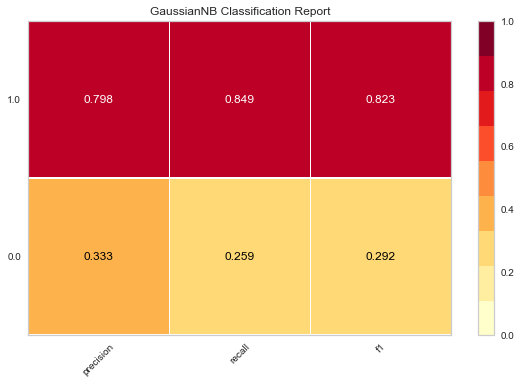

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12b0ad6d8>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x12b1b5cf8>,
                     is_fitted=False, model=None)

In [91]:
classification_report(model1, X_train, y_train, X_test, y_test, is_fitted=False)

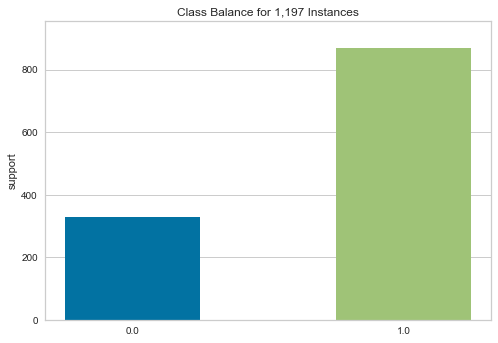

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12b2191d0>)

In [98]:
from yellowbrick.target import class_balance

class_balance(y)

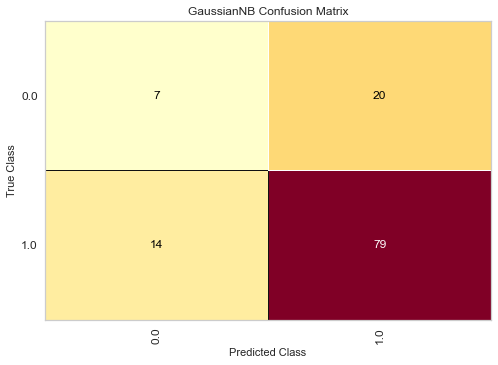

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12b299438>,
                cmap=<matplotlib.colors.ListedColormap object at 0x12b2ab7f0>,
                is_fitted=False, model=None)

In [99]:
confusion_matrix(model1, X_train, y_train, X_test, y_test, is_fitted=False)

In [100]:
from yellowbrick.classifier import roc_auc

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


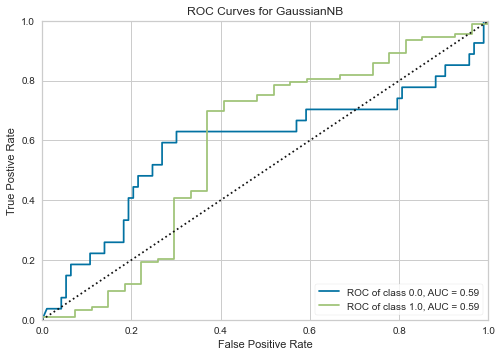

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12b41ee80>,
       is_fitted=False, macro=False, micro=False, model=None)

In [106]:
roc_auc(model1, X_train, y_train, X_test, y_test, per_class=True, macro=False, micro=False, is_fitted=False)

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWar

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: Fut

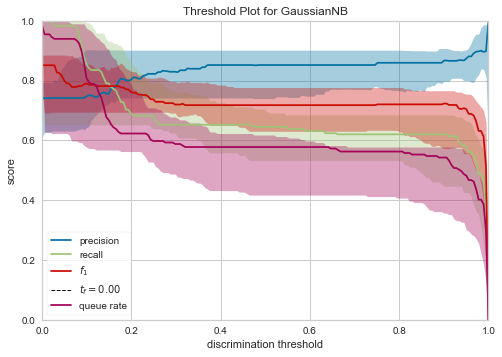

/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/benjamin/.pyenv/versions/3.7.3/envs/georgetown/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


DiscriminationThreshold(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x12b477e48>,
                        cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                        force_model=None, is_fitted=False, model=None)

In [111]:
discrimination_threshold(model1, X, y, cv=TimeSeriesSplit(), is_fitted=False)